### Testing and Experimenting with Results (no useful code here)

In [1]:
import h5py
import matplotlib.pyplot as plt

def inspect_h5_file(h5_path):
    """
    Opens an HDF5 file and prints its contents (groups, datasets, and attributes).
    
    Args:
    - h5_path (str): Path to the HDF5 file.
    """
    with h5py.File(h5_path, 'r') as h5_file:
        print(f"\nContents of {h5_path}:\n")
        
        def print_h5_structure(name, obj):
            """
            Recursively prints the structure of the HDF5 file.
            """
            if isinstance(obj, h5py.Group):
                print(f"[Group] {name}")
            elif isinstance(obj, h5py.Dataset):
                print(f"  [Dataset] {name} - Shape: {obj.shape}, Type: {obj.dtype}")

            if obj.attrs:
                print(f"    Attributes of {name}:")
                for attr_name, attr_value in obj.attrs.items():
                    print(f"{attr_name}: shape - {len(attr_value)}")

        h5_file.visititems(print_h5_structure)

        # Display attributes if present
        for trial_type in h5_file.keys():
            group = h5_file[trial_type]
            if "trial_ids" in group:
                trial_ids = [tid.decode("utf-8") for tid in group["trial_ids"][:5]]  # Show first 5 trial IDs
                print(f"\n{trial_type} - First 5 Trial IDs: {trial_ids}")

# Example usage:
mouse_name = "cfm001"
h5_path = f"results/{mouse_name}_dynamic_spec.h5"
inspect_h5_file(h5_path)


Contents of results/cfm001_dynamic_spec.h5:

[Group] Correct Rejection
    Attributes of Correct Rejection:
Frequencies: shape - 149
OmittedRecordings: shape - 0
OmittedTrials: shape - 0
Time_Array: shape - 314
TrialIDs: shape - 153
  [Dataset] Correct Rejection/DynamicSpectra - Shape: (153, 149, 314), Type: float32
  [Dataset] Correct Rejection/MeanDynamicSpectrum - Shape: (149, 314), Type: float32
  [Dataset] Correct Rejection/TimeSignals - Shape: (153, 314), Type: float32
[Group] False Alarm
    Attributes of False Alarm:
Frequencies: shape - 149
OmittedRecordings: shape - 0
OmittedTrials: shape - 0
Time_Array: shape - 314
TrialIDs: shape - 23
  [Dataset] False Alarm/DynamicSpectra - Shape: (23, 149, 314), Type: float32
  [Dataset] False Alarm/MeanDynamicSpectrum - Shape: (149, 314), Type: float32
  [Dataset] False Alarm/TimeSignals - Shape: (23, 314), Type: float32
[Group] HC Hit
    Attributes of HC Hit:
Frequencies: shape - 149
OmittedRecordings: shape - 0
OmittedTrials: shape -

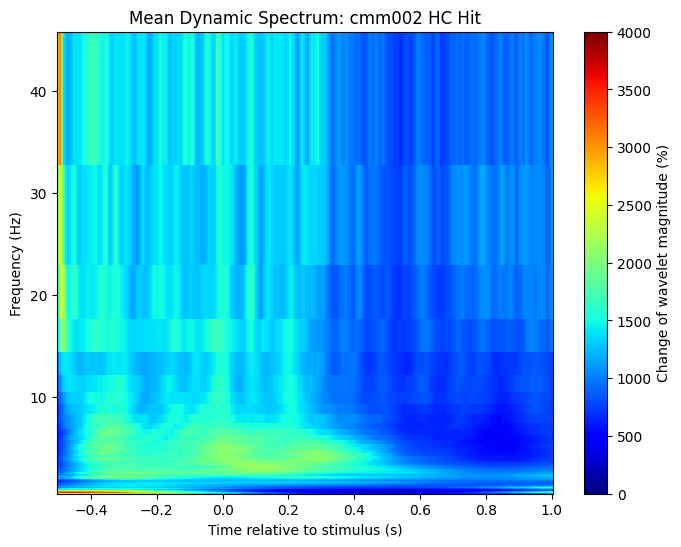

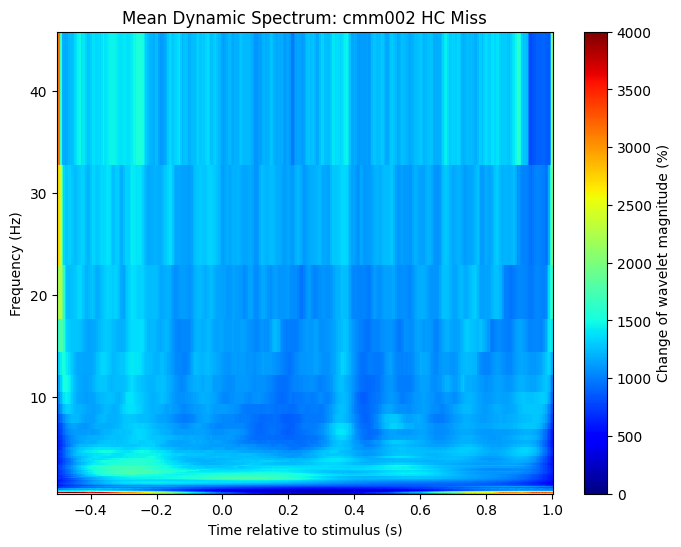

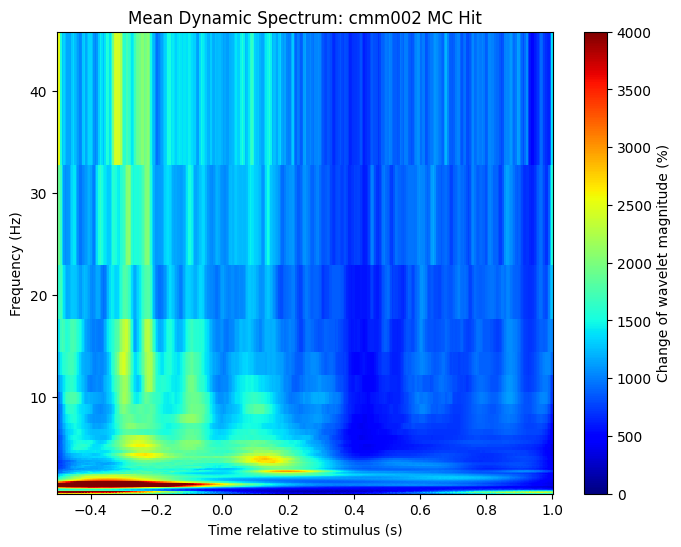

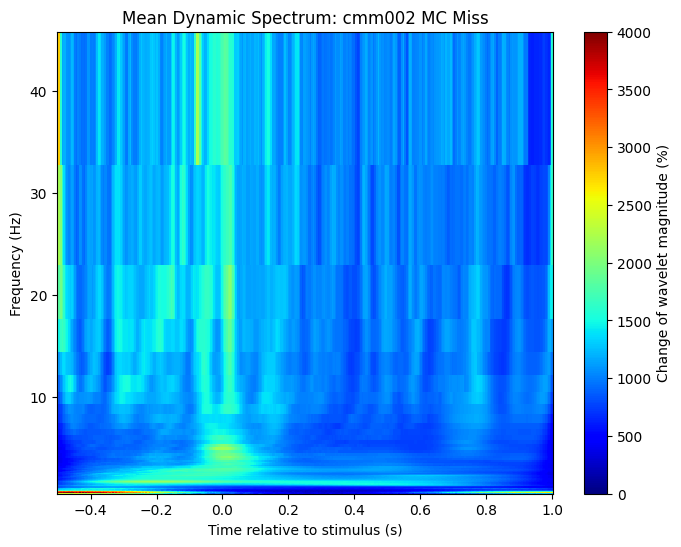

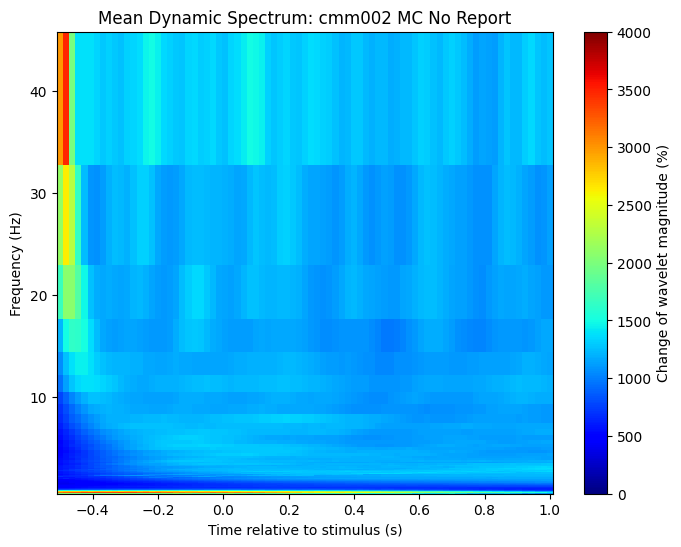

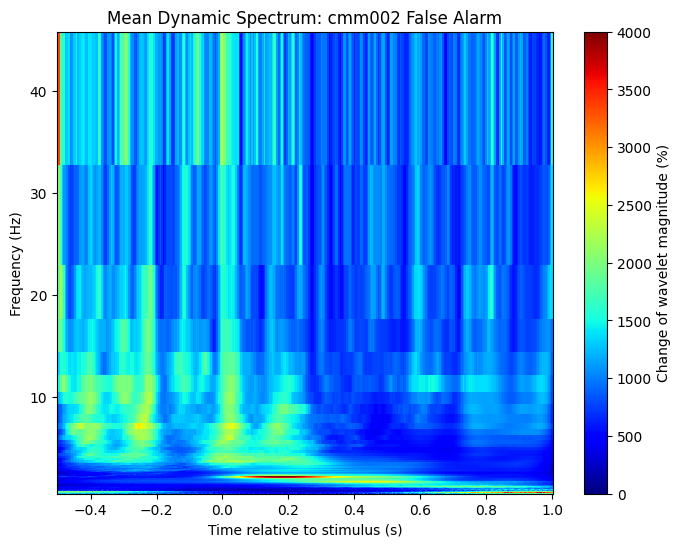

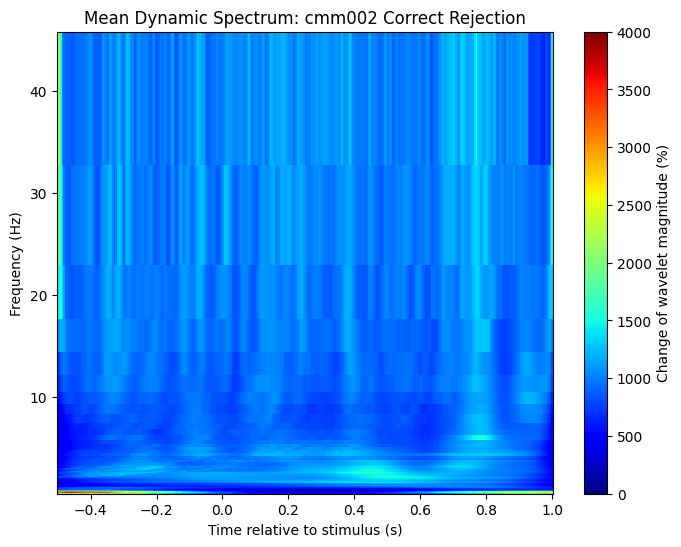

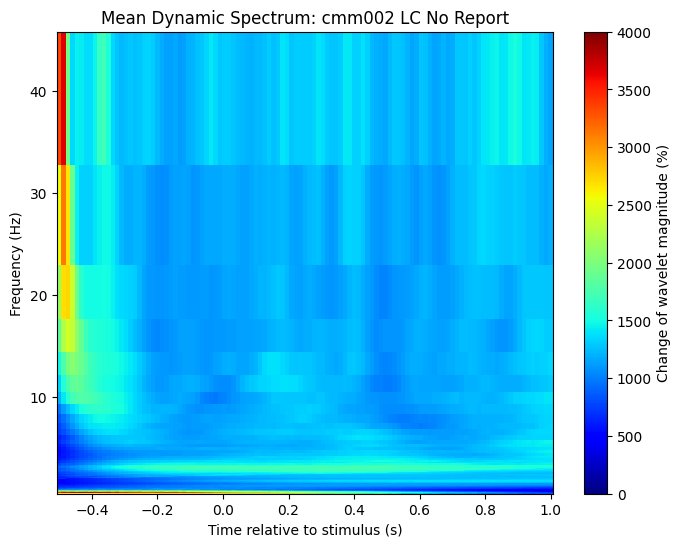

In [12]:
trial_type_names = ['HC Hit', 'HC Miss', 
                    'MC Hit', 'MC Miss', 'MC No Report',
                    'False Alarm', 'Correct Rejection', 'LC No Report']
    
    # Filenames for saving plots and results
file_names = [
        f"{mouse_name}_hc_hit", f"{mouse_name}_hc_miss",
        f"{mouse_name}_mc_hit", f"{mouse_name}_mc_miss", f"{mouse_name}_mc_no_report",
        f"{mouse_name}_false_alarm", f"{mouse_name}_correct_reject", f"{mouse_name}_lc_no_report",
        ]

with h5py.File(h5_path, 'r') as h5_file:
    for i in range(len(trial_type_names)):
        mean_power = h5_file[f'{trial_type_names[i]}/MeanDynamicSpectrum'][()]
        F = h5_file[trial_type_names[i]].attrs['Frequencies'][()]
        T = h5_file[trial_type_names[i]].attrs['Time_Array'][()]
    

        title = f"Mean Dynamic Spectrum: {mouse_name} {trial_type_names[i]}"

        plt.figure(figsize=(8, 6))
        plt.pcolormesh(T, F, mean_power * 100, shading='auto', cmap='jet',
                    vmin=0, vmax=4000)  # Fine-grained frequency resolution
        plt.colorbar(label="Change of wavelet magnitude (%)")
        plt.xlabel("Time relative to stimulus (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title(title)
        plt.savefig(f'dynamic_spectra/cmm002mjr/{file_names[i]}')
        plt.show()
        #plt.close()

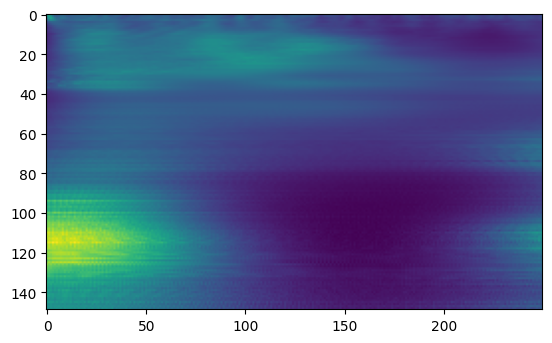

In [7]:
plt.imshow(mean_power)

In [23]:
with h5py.File("results/cfm001_dynamic_spec.h5", "r+") as f:
    if "Correct Rejection" in f:
        del f["Correct Rejection"]
        print('Deleted')

Deleted


In [28]:
with h5py.File("N:/GEVI_Wave/Analysis/Visual/rfm003mjr/20231206/meas00/cG_unmixed_dFF.h5", "r") as f:
    for key in f.keys():
        if isinstance(f[key], h5py.Group):
            print("Top-level group:", key)

Top-level group: movieDFF
Top-level group: specs


In [13]:
import numpy as np
import cv2

with h5py.File("N:/GEVI_Wave/Analysis/Visual/cfm003mjr/20240510/meas02/cG_unmixed_dFF.h5", 'r') as mov_file:
        #mov = mov_file['mov'][()]  
        #movie = np.nan_to_num(mov)
        specs = mov_file["specs"]
        fps = specs["fps"][()][0][0][0]
        timeorigin = specs["timeorigin"][()][0][0][0]
        timebinning = specs["timebinning"][()][0][0]
        timestamps_table = specs["extra_specs"]["timestamps_table"][()].squeeze()
        timestamps_table_names = specs["extra_specs"]["timestamps_table_names"][()]
        timestamps_table_names = b''.join(timestamps_table_names.flatten()).decode("utf-8").split(';')
        # Get the column index for 'behavior_ttl'
        ttl_column = timestamps_table_names.index("behavior_ttl")
        raw_mask = specs["extra_specs"]["mask"][()][0]
        binning = specs["binning"][()][0][0][0]  
        raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()]
        spaceorigin = specs["spaceorigin"][()].flatten()  

        # Extract the raw TTL signal starting from `timeorigin`
        ttl_movie = timestamps_table[ttl_column, int(timeorigin):]

spaceorigin = (spaceorigin - 1) / binning + 1  # Apply space origin transformation

    # Extract all outlines and scale them according to binning
outlines_nums = np.arange(raw_outlines.shape[2]) 
outlines = raw_outlines[:, :, outlines_nums] / binning

outlines[:, 0, :] -= spaceorigin[1] - 1  # Adjust Y-coordinates
outlines[:, 1, :] -= spaceorigin[0] - 1  # Adjust X-coordinates

outline = outlines[37, :, :]  # Shape (2, N)
valid_indices = ~np.isnan(outline).any(axis=0)  # Find non-NaN indices
x_coords = outline[1, valid_indices]
y_coords = outline[0, valid_indices]
#movie_shape = movie.shape[1:3]
#from skimage.draw import polygon2mask
        # Create a mask using polygon2mask
#roi_mask = polygon2mask(movie_shape, np.column_stack((y_coords, x_coords)))
#roi_mask = np.flipud(roi_mask).astype(bool)

#mask = cv2.resize(raw_mask, (0, 0), fx=1/binning, fy=1/binning, interpolation=cv2.INTER_LINEAR)
raw_mask.max()

np.uint8(0)

In [ ]:
trial_type_names = ['HC Hit', 'HC Miss', 
                    'MC Hit', 'MC Miss', 'MC No Report',
                    'False Alarm', 'Correct Rejection', 'LC No Report']
    
    # Filenames for saving plots and results
file_names = [
        f"{mouse_name}_hc_hit", f"{mouse_name}_hc_miss",
        f"{mouse_name}_mc_hit", f"{mouse_name}_mc_miss", f"{mouse_name}_mc_no_report",
        f"{mouse_name}_false_alarm", f"{mouse_name}_correct_reject", f"{mouse_name}_lc_no_report",
        ]

with h5py.File(h5_path, 'r') as h5_file:
    for i in range(len(trial_type_names)):
        mean_power = h5_file[f'{trial_type_names[i]}/MeanDynamicSpectrum'][()]
        F = h5_file[trial_type_names[i]].attrs['Frequencies'][()]

array([0, 0, 0, ..., 0, 0, 0], shape=(1280,), dtype=uint8)

In [20]:
all_mean_power = {
    'HC Hit': [],
    'MC Hit': [],
    'HC Miss': [],
    'MC Miss': []}

for trial_type in ['HC Hit', 'HC Miss', 'MC Hit', 'MC Miss']:
    all_mean_power = []
    for mouse in ['cfm001', 'cfm002', 'cfm003', 'cfm004', 'cmm001', 'cmm002', 'cmm003', 'rfm001', 'rfm002', 'rfm003']:
        with h5py.File(f'results/{mouse}_dynamic_spec.h5', 'r') as h5_file:
            
            mean_power = h5_file[f'{trial_type}/MeanDynamicSpectrum'][()]
            print(mean_power.shape)
            all_mean_power.append(mean_power)
            F = h5_file[trial_type].attrs['Frequencies'][()]
            T = h5_file[trial_type].attrs['Time_Array'][()]

    stacked = np.stack(all_mean_power, axis=0)  # Shape: (n_mice, freq, time)
    final_mean_power = np.mean(stacked, axis=0)

    title = f"Mean Dynamic Spectrum (All Mice): {trial_type}"

    plt.figure(figsize=(8, 6))
    plt.pcolormesh(T, F, mean_power * 100, shading='auto', cmap='jet',
                            vmin=0, vmax=4000)  # Fine-grained frequency resolution
    plt.colorbar(label="Change of wavelet magnitude (%)")
    plt.xlabel("Time relative to stimulus (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.savefig(f'dynamic_spectra/allMice')
    plt.show()
            #plt.close()

(149, 250)
(149, 314)
(149, 314)
(149, 259)
(149, 314)
(149, 112)
(149, 265)
(149, 314)
(149, 155)
(149, 314)


ValueError: all input arrays must have the same shape